In [5]:
#import google cloud related python libraries
from google.datalab import Context
import google.datalab.bigquery as bq
import google.datalab.storage as storage
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO

In [6]:
#import data analysis related python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

#### now lets 
<p>   1. Run a query</p>
<p>   2. Load the results into a pandas dataframe and</p>
<p>   3. Plot using seaborn</p>

In [8]:
%%bq query -n query_eda1
SELECT
  product_name,
  COUNT(*) AS `frequency_count`
FROM
  `newproject-186115.kaggle.mrg_fin`
GROUP BY
  product_name
ORDER BY `frequency_count` DESC

In [9]:
#preview sample from query
%%bq sample --count 5 --query query_eda1

product_name,frequency_count
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584


In [10]:
#load query results into a dataframa
prd_count_df = query_eda1.execute(output_options=bq.QueryOutput.dataframe()).result()

In [12]:
prd_count_df.head(3)

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683


## explore important aisles based on number of occu

In [22]:
%%bq query -n query_eda2
SELECT
  aisle,
  COUNT(*) AS `frequency_count`
FROM
  `newproject-186115.kaggle.mrg_fin`
GROUP BY
  aisle
ORDER BY `frequency_count` DESC
LIMIT 12

In [23]:
#preview query results
%%bq sample --count 5 --query query_eda2

aisle,frequency_count
fresh fruits,3642188
fresh vegetables,3418021
packaged vegetables fruits,1765313
yogurt,1452343
packaged cheese,979763


In [24]:
#load query results into dataframe
aisles_df = query_eda2.execute(output_options=bq.QueryOutput.dataframe()).result()

In [26]:
aisles_df

,aisle,frequency_count
0,fresh fruits,3642188
1,fresh vegetables,3418021
2,packaged vegetables fruits,1765313
3,yogurt,1452343
4,packaged cheese,979763
5,milk,891015
6,water seltzer sparkling water,841533
7,chips pretzels,722470
8,soy lactosefree,638253
9,bread,584834


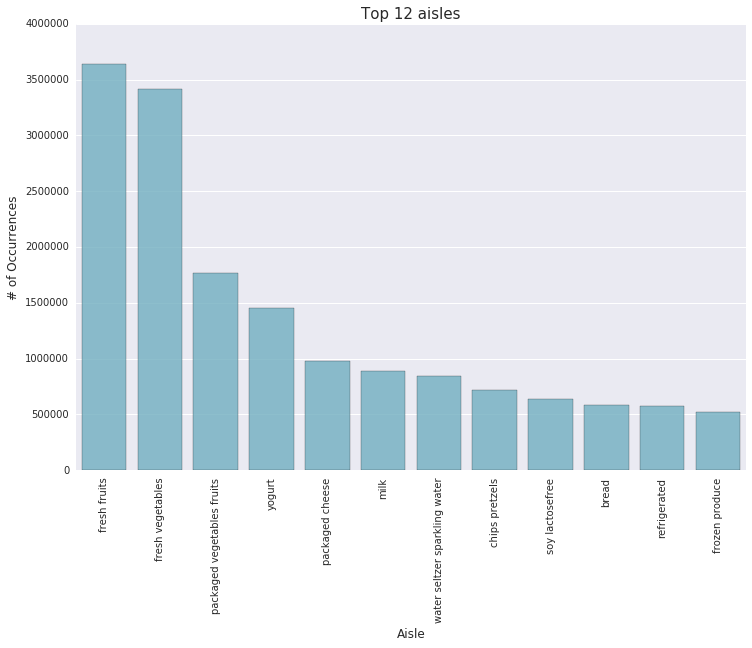

In [27]:
#plot the top 12 aisles with number of occurances
plt.figure(figsize=(12,8))
sns.barplot(aisles_df.aisle, aisles_df.frequency_count, alpha=0.8, color=color[5])
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Top 12 aisles', fontsize=15)
plt.show()

## Department wise orders based on # of occurances

In [3]:
%%bq query -n query_eda3
SELECT
  department,
  COUNT(*) AS `frequency_count`
FROM
  `newproject-186115.kaggle.mrg_fin`
GROUP BY
  department
ORDER BY `frequency_count` DESC

In [5]:
%%bq sample --count 5 --query query_eda3

department,frequency_count
produce,9479291
dairy eggs,5414016
snacks,2887550
beverages,2690129
frozen,2236432


In [6]:
#load query results into a dataframe
dpt_count_df = query_eda3.execute(output_options=bq.QueryOutput.dataframe()).result()

In [7]:
dpt_count_df.head(3)

,department,frequency_count
0,produce,9479291
1,dairy eggs,5414016
2,snacks,2887550


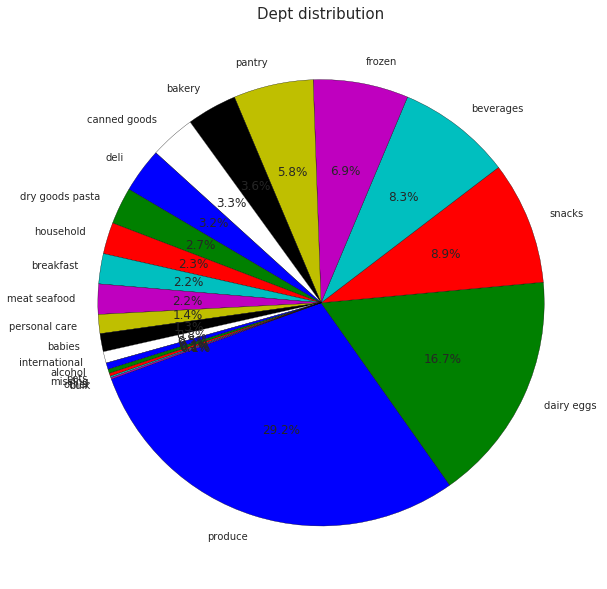

In [29]:
#plot departments distribution
plt.figure(figsize=(10,10))
labels = (np.array(dpt_count_df.department))
sizes = (np.array((dpt_count_df.frequency_count / dpt_count_df.frequency_count.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Dept distribution", fontsize=15)
plt.show()

## reorder ratio w.r.t dept
<p> Here we see which departments have more number of reorders</p>
<p> We need to calculate probability of reorder by aggregating the data set</p>

In [2]:
%%bq query -n query_eda4
SELECT
  department, reordered, Count(*) as counts
FROM
  `newproject-186115.kaggle.mrg_fin`
GROUP BY
  department, reordered
ORDER BY department

In [3]:
%%bq execute --query query_eda4

department,reordered,counts
alcohol,0,66101
alcohol,1,87595
babies,1,245369
babies,0,178433
bakery,0,437599
bakery,1,739188
beverages,1,1757892
beverages,0,932237
breakfast,0,311556
breakfast,1,398013


In [7]:
#load the query results into a dataframe
reor_df = query_eda4.execute(output_options=bq.QueryOutput.dataframe()).result()

In [34]:
#Perform groupby and aggreagation for each department and reorder (0= not reordered, 1= reordered)
reor_22 = reor_df.groupby(['department','reordered']).agg({'counts':np.sum})

In [62]:
reor_22

counts
department      reordered         
alcohol         0            66101
                1            87595
babies          0           178433
                1           245369
bakery          0           437599
                1           739188
beverages       0           932237
                1          1757892
breakfast       0           311556
                1           398013
bulk            0            14623
                1            19950
canned goods    0           579523
                1           488535
dairy eggs      0          1786795
                1          3627221
deli            0           412385
                1           638864
dry goods pasta 0           467046
                1           399581
frozen          0          1024542
                1          1211890
household       0           441591
                1           297075
international   0           169837
                1            99416
meat seafood    0           306489
                1           402442
missing         0            41774
                1            27371
other           0            21485
                1            14806
pantry          0          1225276
                1           650301
personal care   0           303539
                1           143584
pets            0            38964
                1            58760
produce         0          3318581
                1          6160710
snacks          0          1229577
                1          1657973

In [74]:
#reor_df['tot'] = reor_df.groupby('department')['counts'].sum()
rer = reor_df.groupby('department', as_index=False).agg({'counts': np.sum})


In [87]:
#Merge into a single dataframe
newdf = pd.merge(reor_df, rer, on='department')

In [88]:
newdf = newdf.drop('tot', 1)

In [89]:
#rename column names
newdf.rename(columns={'counts_x': 'counts', 'counts_y': 'total'}, inplace=True)
newdf

,department,reordered,counts,total
0,alcohol,0,66101,153696
1,alcohol,1,87595,153696
2,babies,1,245369,423802
3,babies,0,178433,423802
4,bakery,0,437599,1176787
5,bakery,1,739188,1176787
6,beverages,1,1757892,2690129
7,beverages,0,932237,2690129
8,breakfast,0,311556,709569
9,breakfast,1,398013,709569


In [90]:
#We define a new column with probability of reorder
newdf['prob_reorder'] = newdf['counts'] / newdf['total']
newdf

,department,reordered,counts,total,prob_reorder
0,alcohol,0,66101,153696,0.430076
1,alcohol,1,87595,153696,0.569924
2,babies,1,245369,423802,0.578971
3,babies,0,178433,423802,0.421029
4,bakery,0,437599,1176787,0.371859
5,bakery,1,739188,1176787,0.628141
6,beverages,1,1757892,2690129,0.653460
7,beverages,0,932237,2690129,0.346540
8,breakfast,0,311556,709569,0.439078
9,breakfast,1,398013,709569,0.560922


In [91]:
#Keep only reorder=1
newdf = newdf[~(newdf == 0).any(axis=1)]
newdf

,department,reordered,counts,total,prob_reorder
1,alcohol,1,87595,153696,0.569924
2,babies,1,245369,423802,0.578971
5,bakery,1,739188,1176787,0.628141
6,beverages,1,1757892,2690129,0.653460
9,breakfast,1,398013,709569,0.560922
11,bulk,1,19950,34573,0.577040
13,canned goods,1,488535,1068058,0.457405
15,dairy eggs,1,3627221,5414016,0.669969
17,deli,1,638864,1051249,0.607719
18,dry goods pasta,1,399581,866627,0.461076


In [94]:
newdf1 = newdf

In [95]:
newdf1 = newdf1.reset_index()

In [97]:
newdf1 = newdf1.drop('index',1)

In [98]:
newdf1

,department,reordered,counts,total,prob_reorder
0,alcohol,1,87595,153696,0.569924
1,babies,1,245369,423802,0.578971
2,bakery,1,739188,1176787,0.628141
3,beverages,1,1757892,2690129,0.653460
4,breakfast,1,398013,709569,0.560922
5,bulk,1,19950,34573,0.577040
6,canned goods,1,488535,1068058,0.457405
7,dairy eggs,1,3627221,5414016,0.669969
8,deli,1,638864,1051249,0.607719
9,dry goods pasta,1,399581,866627,0.461076


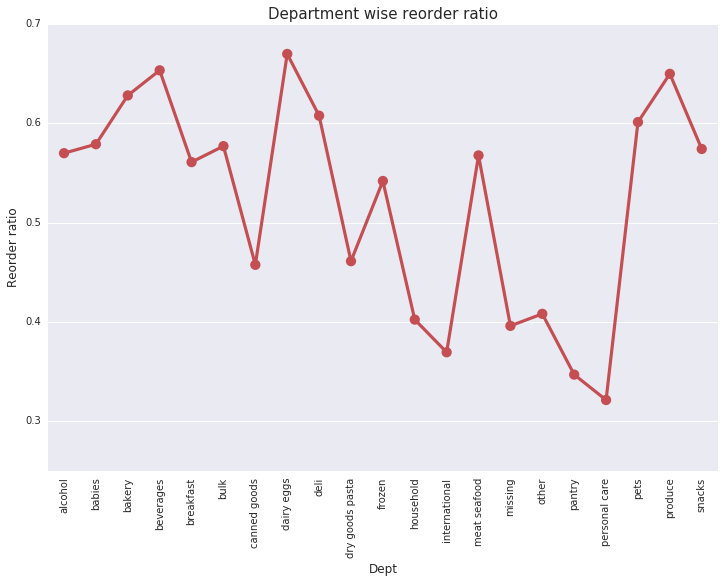

In [102]:
#Plot department wise reorder ratio
plt.figure(figsize=(12,8))
sns.pointplot(newdf1['department'].values, newdf1['prob_reorder'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Dept', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

## reorder ratio w.r.t product name

In [110]:
%%bq query -n query_eda5
SELECT
  product_name, reordered, Count(*) as counts
FROM
  `newproject-186115.kaggle.mrg_fin`
GROUP BY
  product_name, reordered
ORDER BY counts DESC
LIMIT 11

In [111]:
%%bq execute --query query_eda5

product_name,reordered,counts
Banana,1,398609
Bag of Organic Bananas,1,315913
Organic Strawberries,1,205845
Organic Baby Spinach,1,186884
Organic Hass Avocado,1,170131
Organic Avocado,1,134044
Organic Whole Milk,1,114510
Large Lemon,1,106255
Organic Raspberries,1,105409
Strawberries,1,99802


In [112]:
#Load query results into a dataframe
prod_df = query_eda5.execute(output_options=bq.QueryOutput.dataframe()).result()

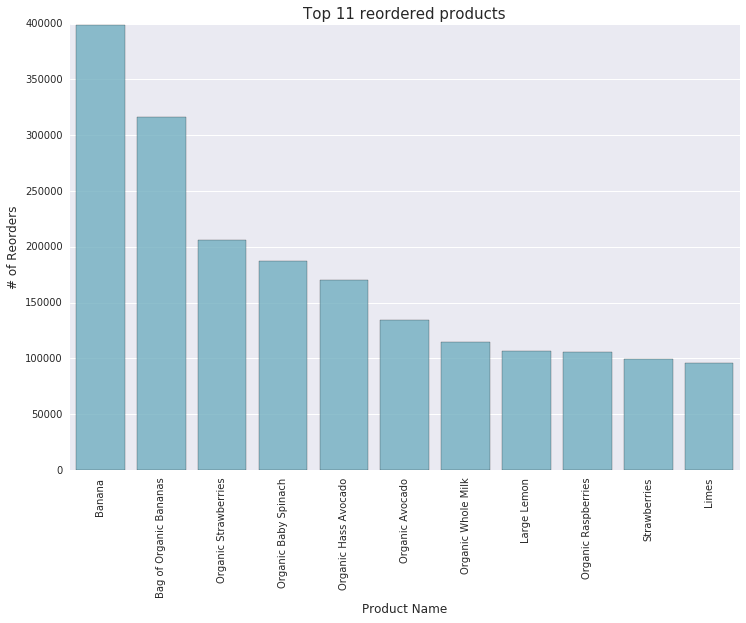

In [113]:
#Plot the 11 most reordered products
plt.figure(figsize=(12,8))
sns.barplot(prod_df.product_name, prod_df.counts, alpha=0.8, color=color[5])
plt.ylabel('# of Reorders', fontsize=12)
plt.xlabel('Product Name', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Top 11 reordered products', fontsize=15)
plt.show()

## 'time since previous order' vs 'probability of reorder'
<p> We like to see how the time from last order placed affect reordering</p>

In [115]:
%%bq query -n query_eda6
SELECT
  days_since_prior_order, reordered, Count(*) as counts
FROM
  `newproject-186115.kaggle.mrg_new_1`
GROUP BY
  days_since_prior_order, reordered
ORDER BY days_since_prior_order

In [116]:
%%bq execute --query query_eda6

days_since_prior_order,reordered,counts
0,0,2195287
0,1,331479
1,0,359860
1,1,581256
2,1,945487
2,0,519388
3,1,1255573
3,0,622308
4,0,670852
4,1,1409708


In [117]:
reor_df1 = query_eda6.execute(output_options=bq.QueryOutput.dataframe()).result()

In [118]:
#Aggregate on number of days since most recent order
#This shows how many reorders occur after most recent purchase day
rer2 = reor_df1.groupby('days_since_prior_order', as_index=False).agg({'counts': np.sum})
rer2

,days_since_prior_order,counts
0,0,2526766
1,1,941116
2,2,1464875
3,3,1877881
4,4,2080560
5,5,2126420
6,6,2519939
7,7,3479504
8,8,1933815
9,9,1218973


In [120]:
newdf1 = pd.merge(reor_df1, rer2, on='days_since_prior_order')
newdf1

,days_since_prior_order,reordered,counts_x,counts_y
0,0,0,2195287,2526766
1,0,1,331479,2526766
2,1,0,359860,941116
3,1,1,581256,941116
4,2,1,945487,1464875
5,2,0,519388,1464875
6,3,1,1255573,1877881
7,3,0,622308,1877881
8,4,0,670852,2080560
9,4,1,1409708,2080560


In [121]:
#Rename the column name
newdf1.rename(columns={'counts_x': 'counts', 'counts_y': 'total'}, inplace=True)
newdf1

,days_since_prior_order,reordered,counts,total
0,0,0,2195287,2526766
1,0,1,331479,2526766
2,1,0,359860,941116
3,1,1,581256,941116
4,2,1,945487,1464875
5,2,0,519388,1464875
6,3,1,1255573,1877881
7,3,0,622308,1877881
8,4,0,670852,2080560
9,4,1,1409708,2080560


In [122]:
#Calculate probability of reorder
newdf1['prob_reorder'] = newdf1['counts'] / newdf1['total']
newdf1

,days_since_prior_order,reordered,counts,total,prob_reorder
0,0,0,2195287,2526766,0.868813
1,0,1,331479,2526766,0.131187
2,1,0,359860,941116,0.382376
3,1,1,581256,941116,0.617624
4,2,1,945487,1464875,0.645439
5,2,0,519388,1464875,0.354561
6,3,1,1255573,1877881,0.668612
7,3,0,622308,1877881,0.331388
8,4,0,670852,2080560,0.322438
9,4,1,1409708,2080560,0.677562


In [123]:
#Keep data with only reordered = 1
newdf1 = newdf1[~(newdf1 == 0).any(axis=1)]
newdf1

,days_since_prior_order,reordered,counts,total,prob_reorder
3,1,1,581256,941116,0.617624
4,2,1,945487,1464875,0.645439
6,3,1,1255573,1877881,0.668612
9,4,1,1409708,2080560,0.677562
11,5,1,1433248,2126420,0.674019
12,6,1,1706157,2519939,0.677063
15,7,1,2413674,3479504,0.693683
17,8,1,1296234,1933815,0.670299
18,9,1,793570,1218973,0.651015
21,10,1,623383,968153,0.643889


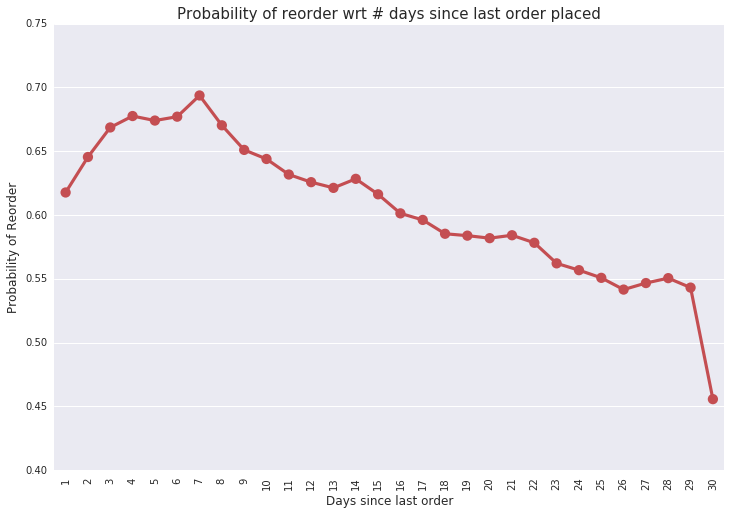

In [124]:
#Plot probability of reorder and number of days since last order
plt.figure(figsize=(12,8))
sns.pointplot(newdf1['days_since_prior_order'].values, newdf1['prob_reorder'].values, alpha=0.8, color=color[2])
plt.ylabel('Probability of Reorder', fontsize=12)
plt.xlabel('Days since last order', fontsize=12)
plt.title("Probability of reorder wrt # days since last order placed", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()